# Experiment 1

**Hypothesis**: Expit-transformed probabilities of current KG Embedding Models are uncalibrated, but off-the-shelf calibration techniques can effectively make the uncalibrated probabilities calibrated.

Extending the setting of the previous work by Tabacof et al, in our experiment, we trained 4 typical KG embedding models:
- TransE
- ComplEx
- DistMult
- HolE

on 6 datasets:

- FB13k
- WN11
- YAGO39
- DBpedia50
- Kinship
- UMLS

Each dataset is split into 3 subsets for training, calibration, and testing. Note that the calibration and testing sets of FB13, WN11 and YAGO39 have ground truth negative samples, while the other 4 don't. Therefore, we generated synthetic negative samples via the corruption and local closed world assumption.

In [1]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

In [2]:
from copy import deepcopy
from typing import Iterable, Callable, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit

In [3]:
from probcalkge import Experiment, ExperimentResult
# from probcalkge import get_calibrators
from probcalkge.calmodels2 import get_calibrators
from probcalkge import get_datasets,  get_kgemodels
from probcalkge import brier_score, negative_log_loss, ece, cal_curve, accuracy
from probcalkge import get_cls_name

In [4]:
ds = get_datasets()
cals = get_calibrators()
kges = get_kgemodels()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [5]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, cals.beta, cals.histbin], 
    datasets=[ds.fb13, ds.wn18, ds.yago39, ds.dp50, ds.kinship, ds.umls], 
    kges=[kges.transE, kges.complEx, kges.distMult, kges.hoLE], 
    metrics=[brier_score, negative_log_loss, ece]
    )

In [6]:
# exp_res = exp.run()
exp.load_trained_kges('../saved_models/trained_kges')
exp_res = exp.run_with_trained_kges()

Loaded trained KG embedding models.
training various calibrators for TransE on FB13k ...
training various calibrators for ComplEx on FB13k ...
training various calibrators for DistMult on FB13k ...
training various calibrators for HolE on FB13k ...
training various calibrators for TransE on WN11 ...
training various calibrators for ComplEx on WN11 ...
training various calibrators for DistMult on WN11 ...
training various calibrators for HolE on WN11 ...
training various calibrators for TransE on YAGO39 ...
training various calibrators for ComplEx on YAGO39 ...
training various calibrators for DistMult on YAGO39 ...
training various calibrators for HolE on YAGO39 ...
training various calibrators for TransE on DBpedia50 ...
training various calibrators for ComplEx on DBpedia50 ...
training various calibrators for DistMult on DBpedia50 ...
training various calibrators for HolE on DBpedia50 ...
training various calibrators for TransE on Kinship ...
training various calibrators for ComplEx 

In [7]:
def plot_metrics(metric):
    plt.rc('figure', dpi=100) # default for me was 75
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=5)
    plt.rc('legend', fontsize=5)
    plt.rc('lines', linewidth=2)
    plt.rc('lines', markersize=2)
    plt.rc('figure', titlesize=15)

    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)
    
    fig.supylabel(metric.__name__, fontsize=10)
    fig.subplots_adjust(left=0.1)

    res = {}
    for i, data in enumerate(exp.datasets):
        res[data.name] = {}
        for j, kge in enumerate(exp.trained_kges[data.name].values()):
            res[data.name][kge.name] = []
            for cal in  exp.trained_cals[data.name][kge.name].values():
                scores = kge.predict(data.X_test)
                probs = cal.predict(expit(scores))
                if get_cls_name(kge) == 'TransE' and cal.name == 'UncalCalibrator':
                    probs = probs * 2 # expit probs of TransE [0, 0.5] -> [0, 1] 
                # print(f'{data.name}-{kge.name}-{cal.name}   {accuracy_score(data.y_test, preds)}')
                res[data.name][kge.name].append(metric(data.y_test, probs))


    for i, k in enumerate(res.keys()):
        ax = axes[i // 3][i % 3]
        # ax = axes[i]
        ax = pd.DataFrame(res[k], index=['Uncal', 'Platt', 'Isot', 'beta', 'histbin', ]).T.round(3).plot(kind='bar', ax=ax)
        # ax.set_xlabel('KGE models ')
        ax.set_xticklabels(['TransE', 'ComplEx', 'DistMult', 'HoLE'], rotation=45)
        # ax.set_ylabel(metric.__name__)
        ax.set_title(f'{k}')
        # ax.set_ylim(0, 1.0)
        if k != 'FB13k':
            ax.legend()
            ax.get_legend().remove()


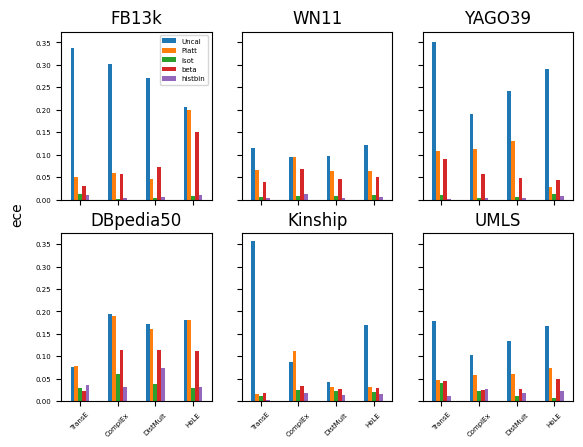

In [8]:
plot_metrics(ece)

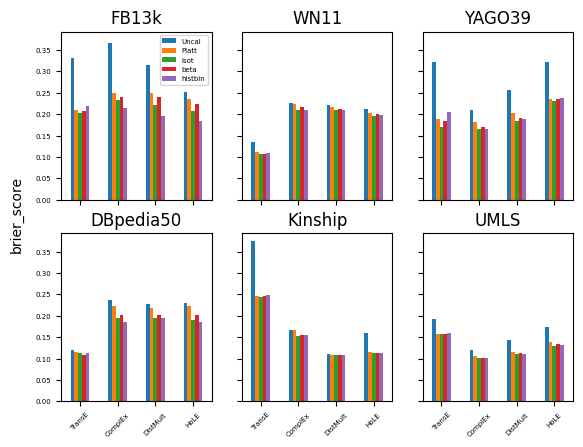

In [9]:
plot_metrics(brier_score)

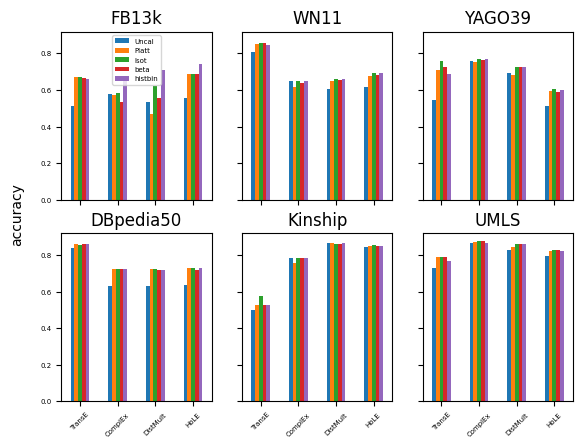

In [10]:
plot_metrics(accuracy)